# Exploration of Data Science Bowl 2018 dataset
## Overview
The dataset and its description can be found here: https://www.kaggle.com/c/data-science-bowl-2018
This dataset contains a large number of segmented nuclei images. The images were acquired under a variety of conditions and vary in the cell type, magnification, and imaging modality (brightfield vs. fluorescence). The dataset is designed to challenge an algorithm's ability to generalize across these variations.
Each image is represented by an associated ImageId. Files belonging to an image are contained in a folder with this ImageId. Within this folder are two subfolders:
- images contains the image file.
- masks contains the segmented masks of each nucleus. This folder is only included in the training set. Each mask contains one nucleus. Masks are not allowed to overlap (no pixel belongs to two masks).

**Note: you need a kaggle account and installed kaggle API in order to work with this notebood. Please refer https://github.com/Kaggle/kaggle-api for more details.**

In [14]:
% matplotlib inline
import cv2
from dsb import DataScienceBowl2018
from data_helper import show_empty_masks, show_data, show_data_from_generator
from matplotlib import pyplot as plt
import numpy as np
import os

## Create dataset helper class and download the dataset

In [4]:
dataset_root = './datasets/data-science-bowl-2018-2'
dataset = DataScienceBowl2018(dataset_root)

In [6]:
# clear existing data from the disk
dataset.clear()

In [7]:
dataset.download()

## Review of original images and corresponded maskd
The helper class combines masks of separated nucleus to a slide mask which contains outlines of all nuclei in the slide. The dataset class provides a generator that allows iterating through images and combined masks. Picture below shows a subset of the dataset. One row or the picture shows original images, another - corresponded combined masks.
The dataset contains images of different sizes and different brightness.

In [9]:
generator = dataset.source_generator()
show_data_from_generator(generator,3, 10, (25,15))

## Create training, validation and test sets
In order to create representative training, validation and test image sets we need that images of different types are represented equaly by different sets. To achieve it, we create clusters of images according to their sizes and raster statistics.

**Create a pandas DataFrame object with image parameters**

In [10]:
df = dataset.compute_image_stats()
df.head()

name       min       max  \
0  eb96fc6cbf6880bf05c4309857ae33844a4bc2152e228e...  0.035294  1.000000   
1  6fe2df6de1d962b90146c822bcefc84d0d3d6926fdfbac...  0.000000  0.800000   
2  0e21d7b3eea8cdbbed60d51d72f4f8c1974c5d76a8a389...  0.172549  0.705882   
3  bf7691b0a79811fa068b7408cbce636a73f01ef9e971a9...  0.039216  1.000000   
4  c9f305be17312bdb9530fb4f1adc6d29730ddbe0e74730...  0.015686  0.164706   

        std      mean     width    height  
0  0.048095  0.060858  0.250000  0.250000  
1  0.055696  0.051071  0.507812  0.679688  
2  0.069249  0.652438  0.250000  0.312500  
3  0.129461  0.100992  0.250000  0.250000  
4  0.033632  0.045755  0.351562  0.351562

** Split dataset by 8 clasters according to their raster statistics and size **

In [12]:
dataset.create_image_clusters(df,cluster_count=8)
df.head()

name       min       max  \
0  eb96fc6cbf6880bf05c4309857ae33844a4bc2152e228e...  0.035294  1.000000   
1  6fe2df6de1d962b90146c822bcefc84d0d3d6926fdfbac...  0.000000  0.800000   
2  0e21d7b3eea8cdbbed60d51d72f4f8c1974c5d76a8a389...  0.172549  0.705882   
3  bf7691b0a79811fa068b7408cbce636a73f01ef9e971a9...  0.039216  1.000000   
4  c9f305be17312bdb9530fb4f1adc6d29730ddbe0e74730...  0.015686  0.164706   

        std      mean     width    height  cluster  
0  0.048095  0.060858  0.250000  0.250000        4  
1  0.055696  0.051071  0.507812  0.679688        6  
2  0.069249  0.652438  0.250000  0.312500        1  
3  0.129461  0.100992  0.250000  0.250000        4  
4  0.033632  0.045755  0.351562  0.351562        2

**Visualize different clusters**
Picture below shows first 10 images from each of 8 clusters

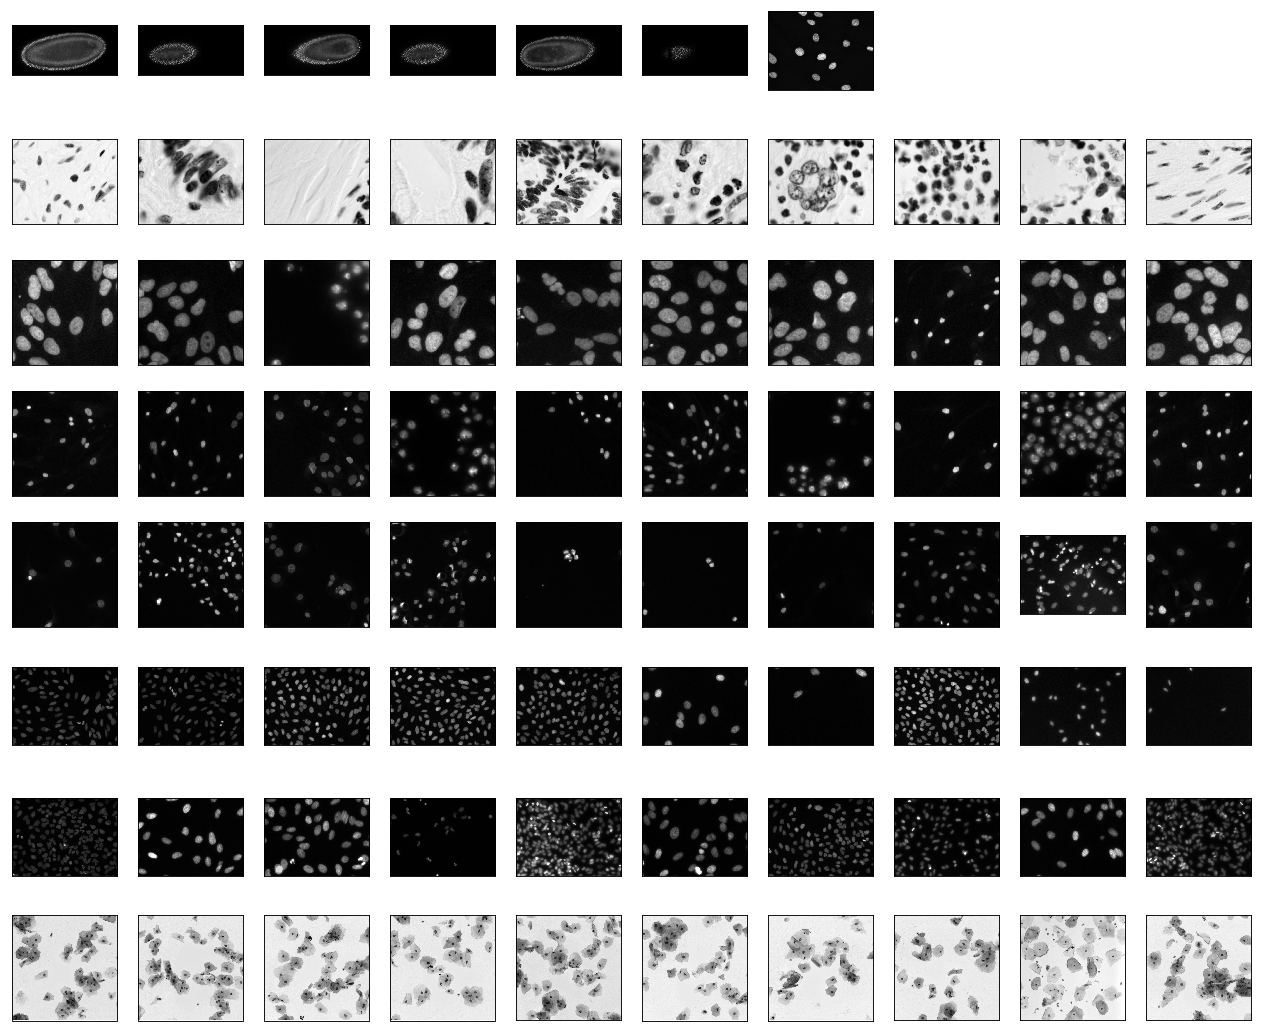

In [17]:
clusters = df.cluster.max() + 1
cols = 10
rows = clusters
plt.figure(figsize=(20,17),dpi=80)

for cluster in range(clusters):
    df0 = df[df.cluster==cluster]
    image_num = 0
    for index, image_info in df0.iterrows():
        image_name = image_info['name']
        image_path = os.path.join(dataset_root, 'data', image_name, 'images', image_name + '.png')
        image = cv2.imread(image_path, 0)
        image = image/255.
        plt.subplot2grid((rows,cols),(cluster, image_num))
        plt.imshow(image, cmap='gray')
        plt.xticks([])
        plt.yticks([])
        image_num += 1
        if image_num >= cols:
            break
plt.show()

## Dataset preparation
***prepare*** method of the dataset helper splits the dataset in 3 subsets for training, validation and testing.
It performes as well following operations:
- combination of a slide masks in a single mask with outlines of all slide nuclei;
- invert bright slides;
- defines the training, validation and test datasets by clustering of images according to the image raster statistics and making sure that each set contains equal amount of images from the clusters; 
- splits slides to tiles 256x256. The tiles normally overlap with each other;

In [18]:
dataset.prepare()

### Show some preprocessed training images
This section shows 256x256 tiles created from the original images together with corresponded masks

Found 1929 images belonging to 1 classes.
Found 1929 images belonging to 1 classes.


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image.py:1131: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


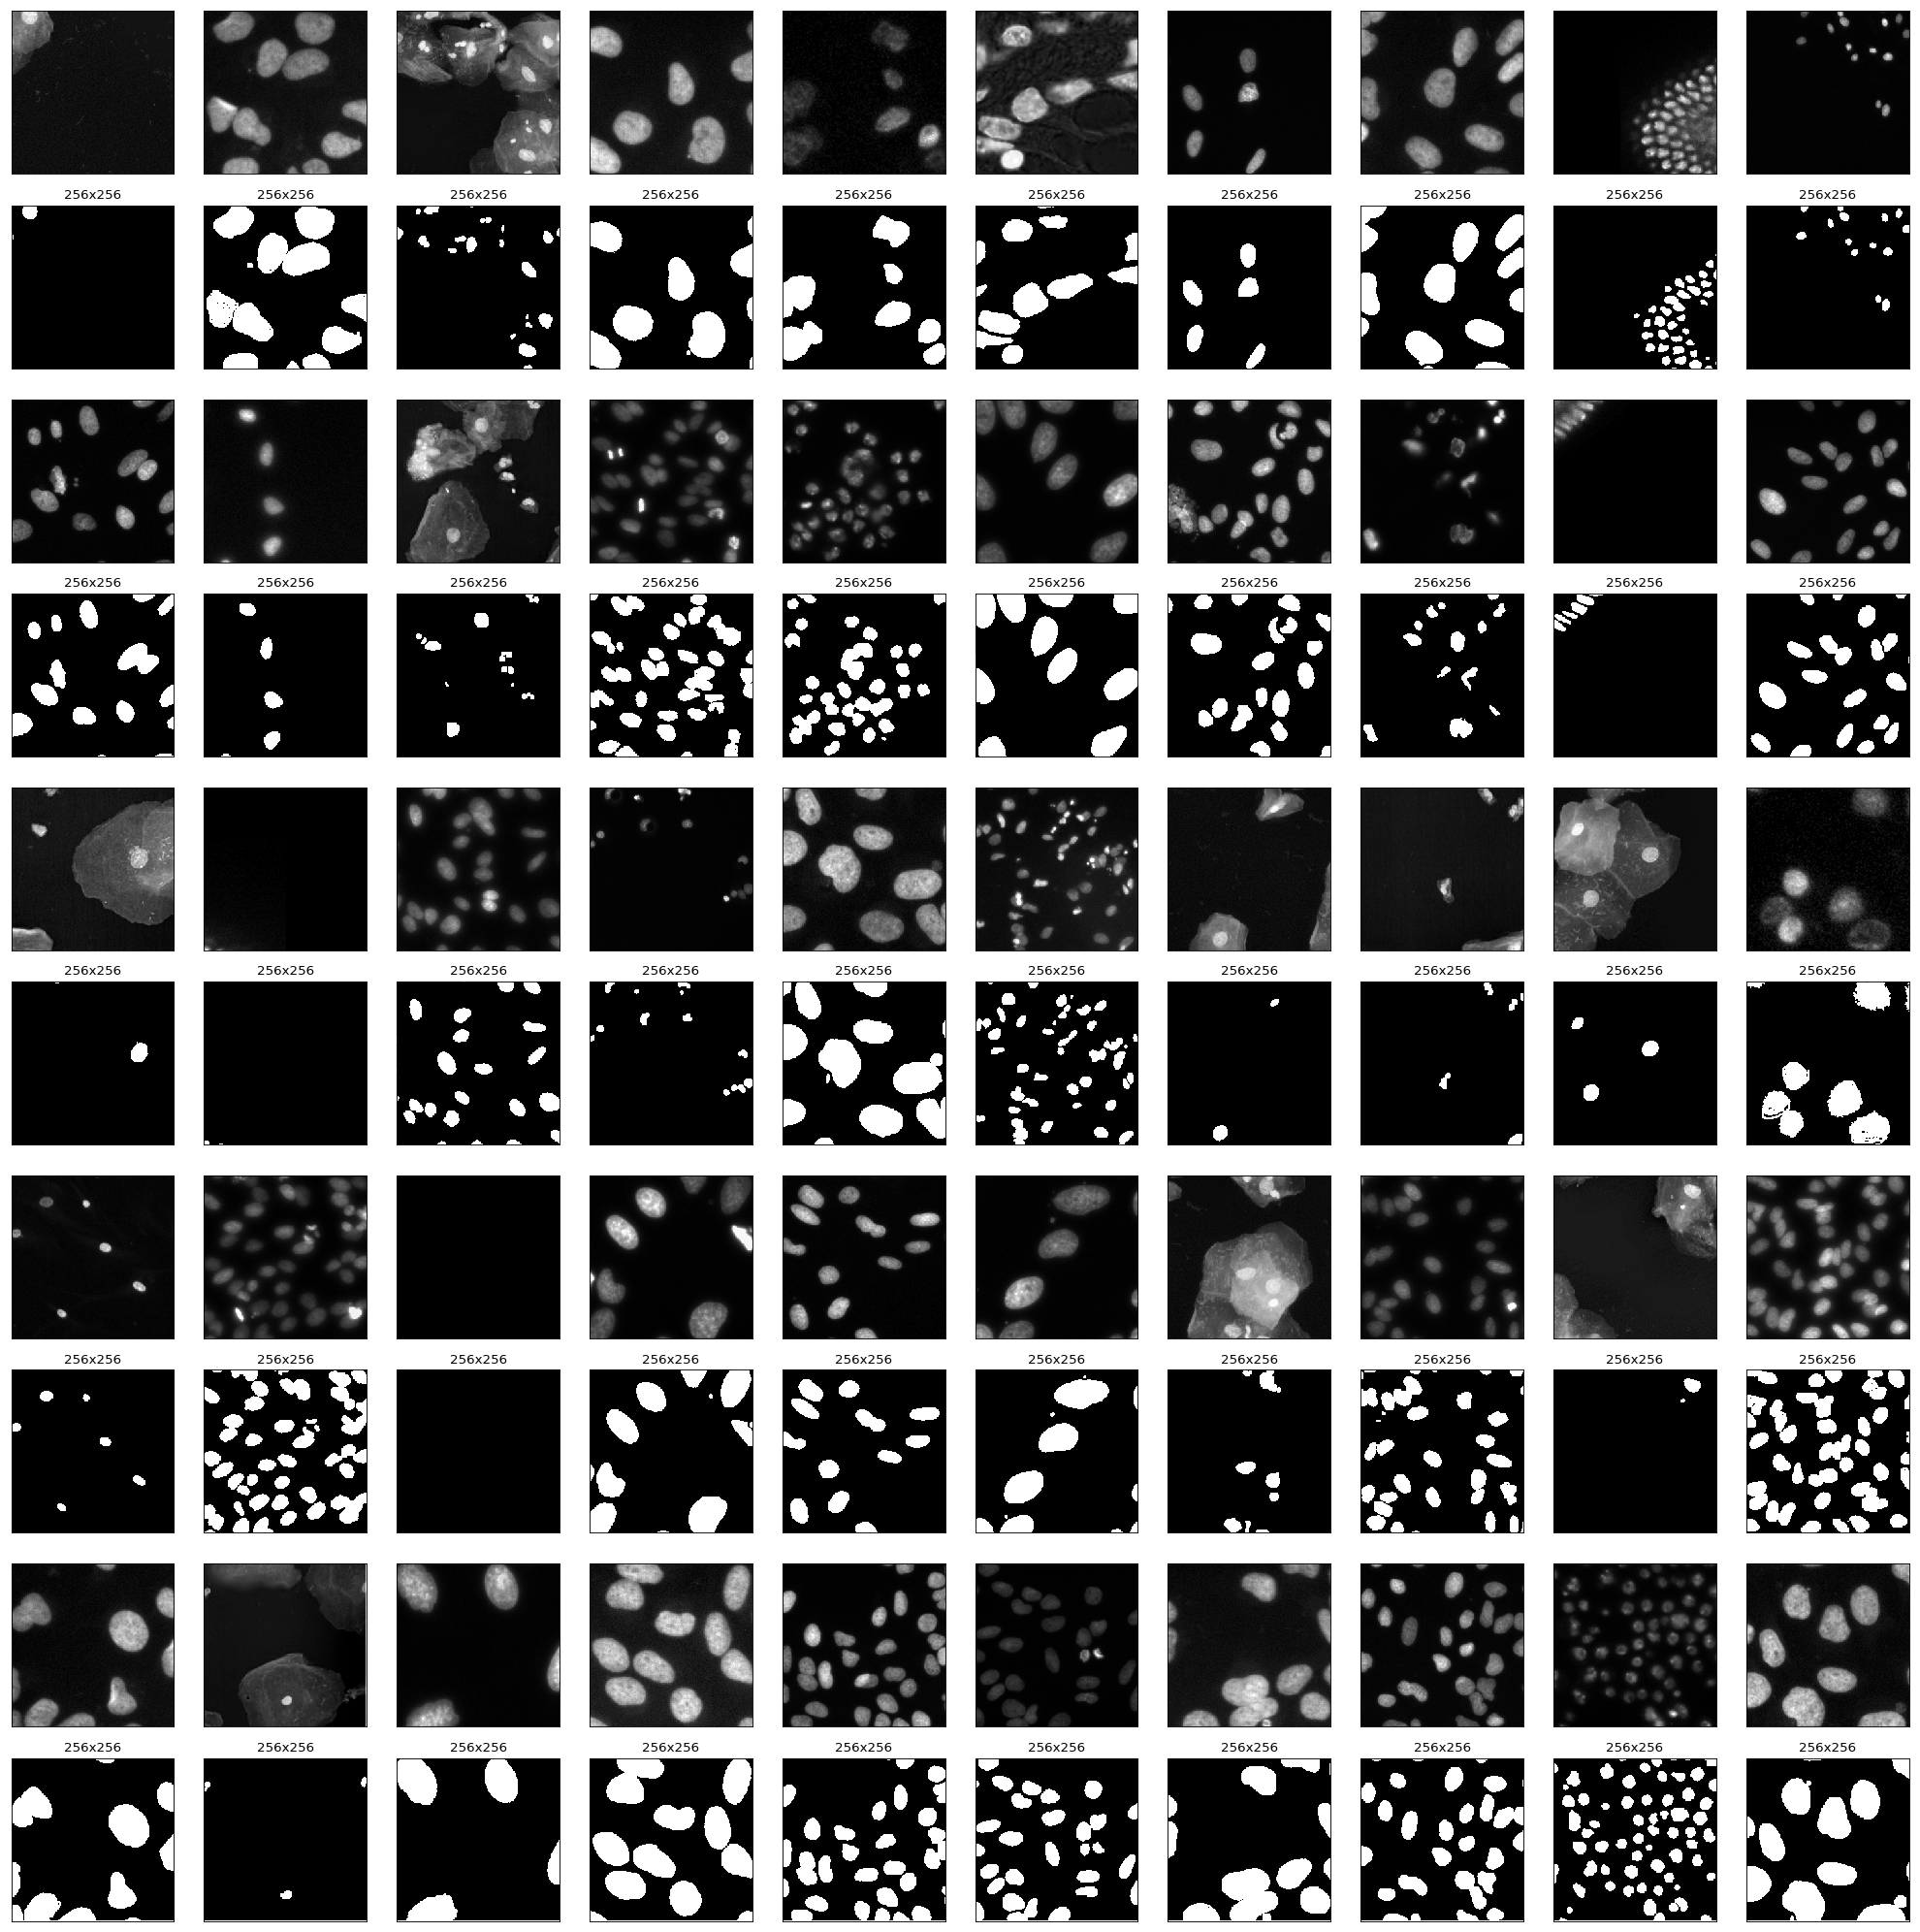

In [19]:
generator = dataset.generator(mode='training')
show_data_from_generator(generator,5, 10, (25,25))

### Show some preprocessed validation images
This section shows several images and masks from the validation set

Found 290 images belonging to 1 classes.
Found 290 images belonging to 1 classes.


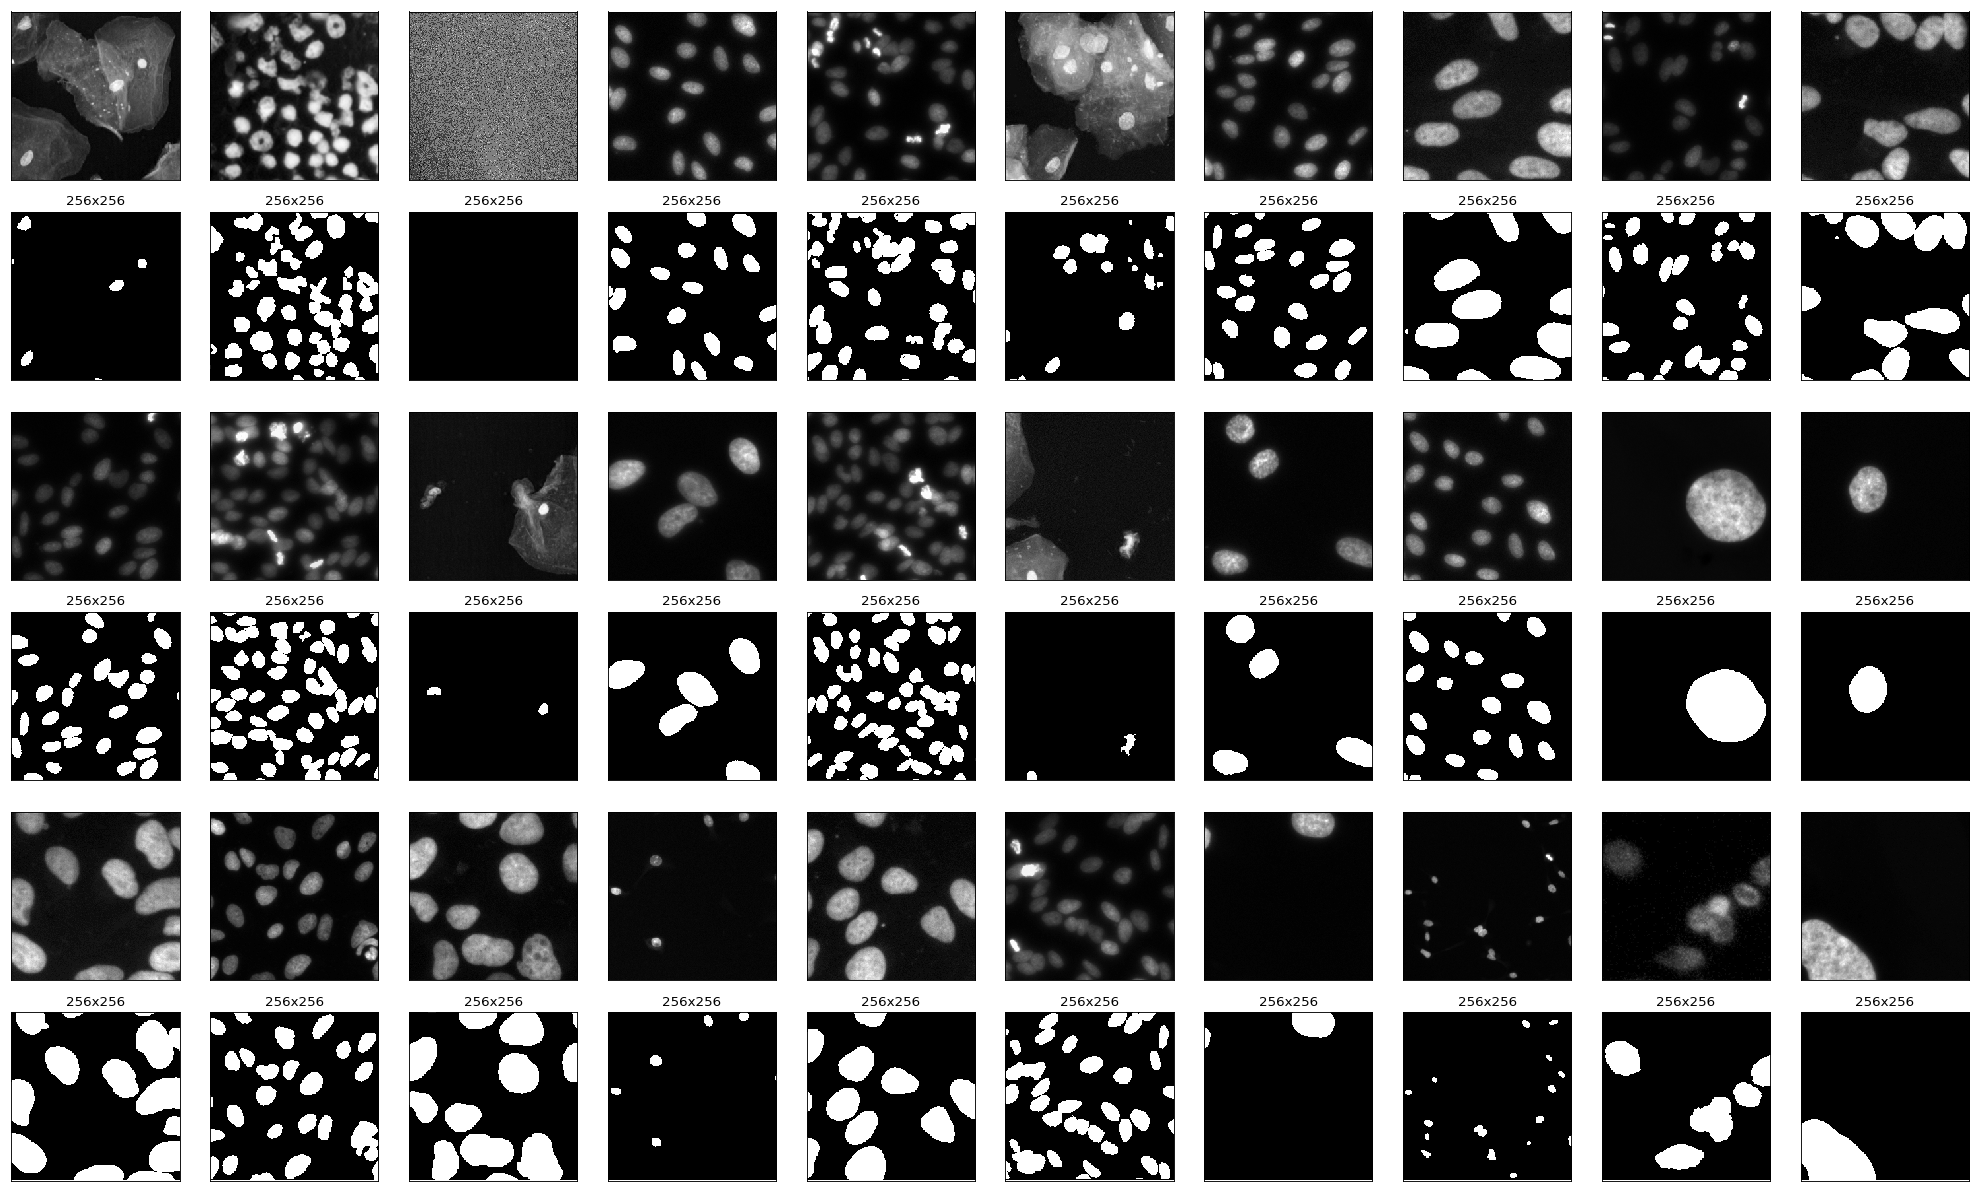

In [20]:
generator = dataset.generator(mode='validation')
show_data_from_generator(generator,3, 10, (25,15))

### Show some testing images (not preprocessed)
This section shows test images and corresponded nucleus masks. The images are not tiled nor preprocess. Tiling, preprocessing and combining of the prediction results occurs in the inferrence process.

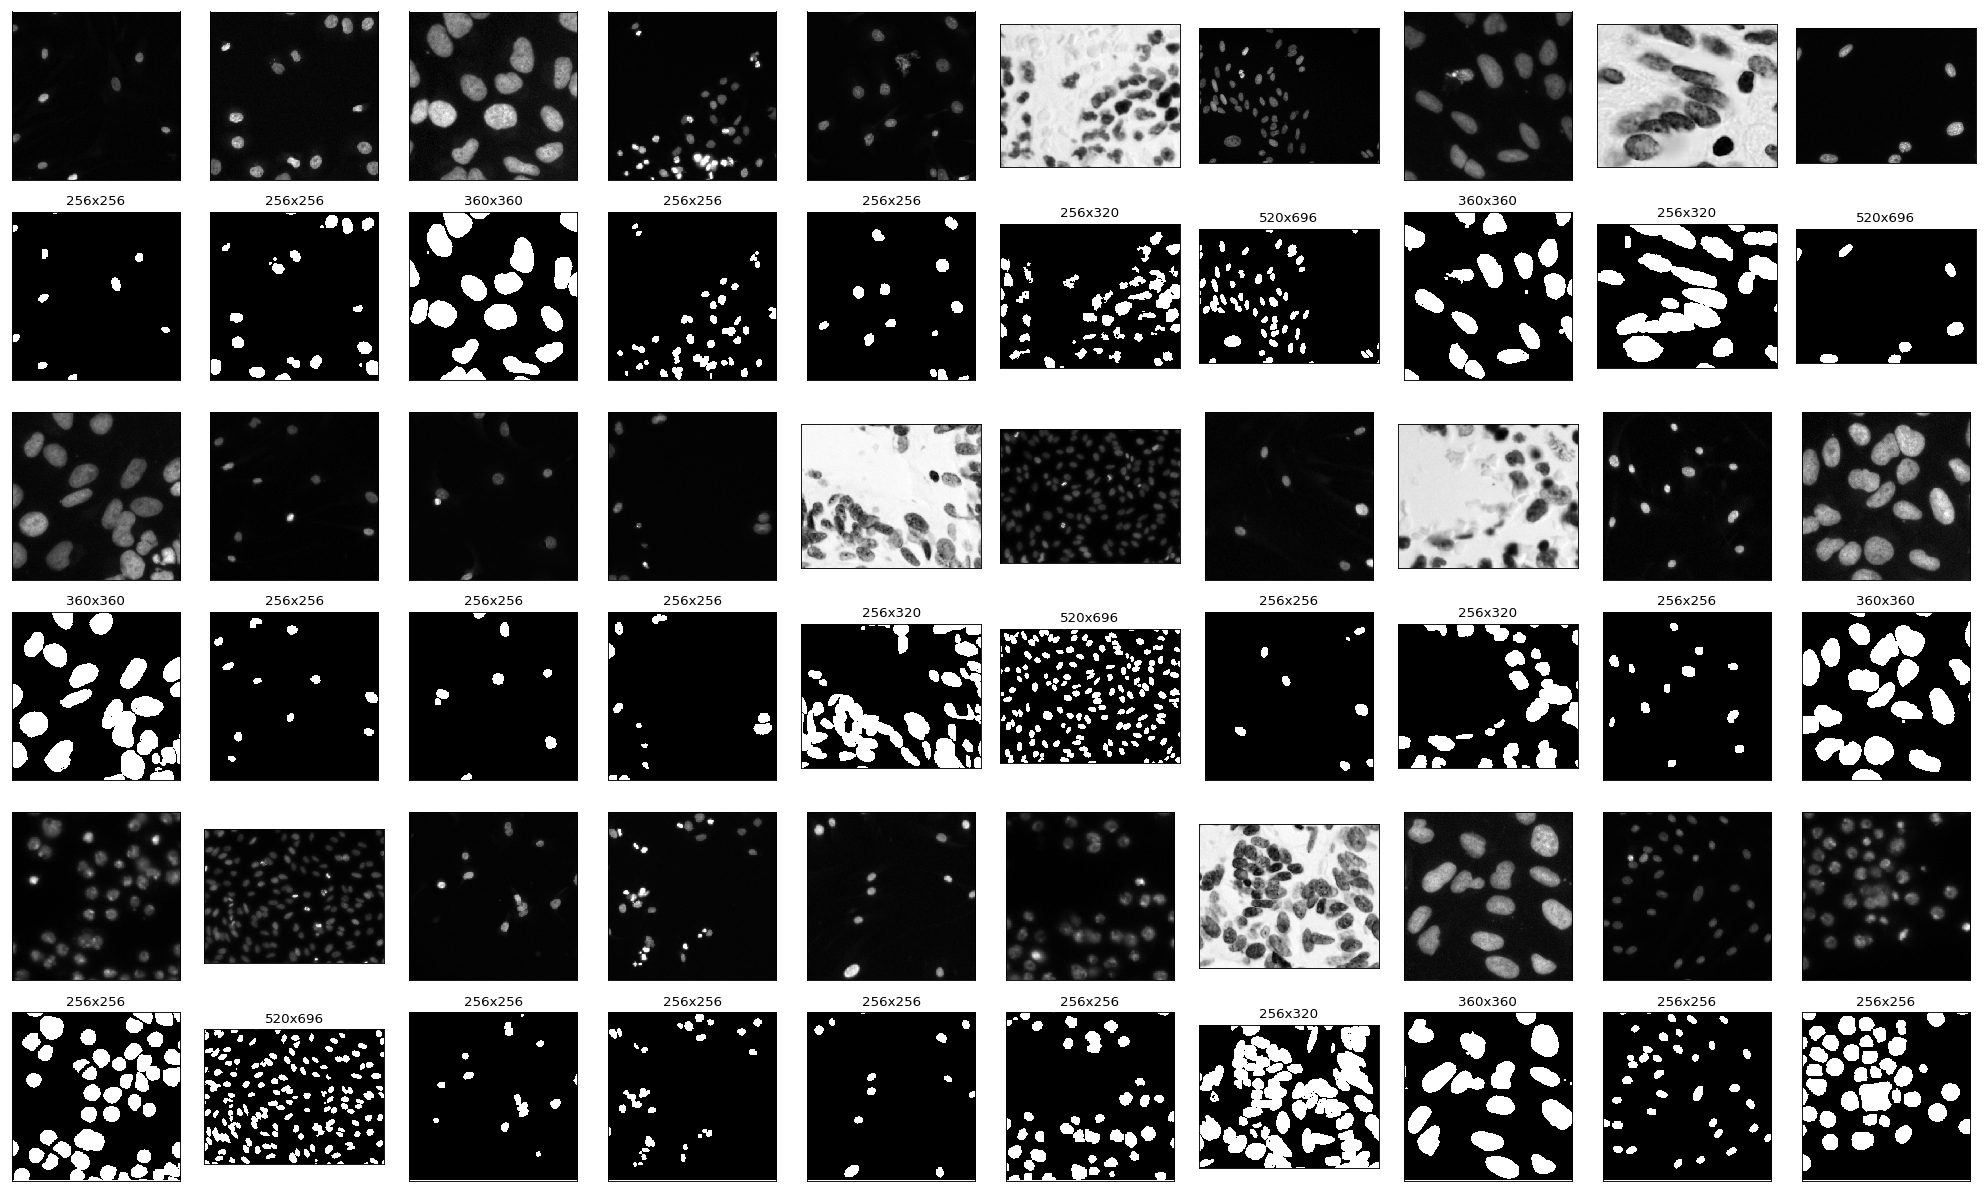

In [21]:
generator = dataset.generator(mode='test')
show_data_from_generator(generator,3, 10, (25,15))